# ANHIR: Evaluation Board

This notebook serves as visualisation for challenge results in several forms - standard tables and charts. First, all submissions have to be recomputed, so they also contain the detail about each image registration pair. One of the perspective to validate is the difference between training and testing.

The ANHIR challenge is hosted on https://anhir.grand-challenge.org.

These particular results are for ANHIR workshop hosted at ISBI 2019 in Venice, Italy.
In case you want to get some further evaluation related to new submission, you may contact one of the ANHIR administrators because the full submission is required, see https://anhir.grand-challenge.org/Organizers.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking, grouping_cumulative
from birl.utilities.drawing import RadarChart, draw_matrix_user_ranking, draw_scatter_double_scale
from birl.benchmark import ImRegBenchmark
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [2]:
# folder with all participants submissions
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions_paper')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
# configuration needed for recomputing detail metrics
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')
FIELD_TISSUE = 'type-tissue'
FIELD_STATUS = 'Status'

pd.set_option("display.max_columns", 25)

## Parse and load submissions

### Extract metrics from particular submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [3]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip -o "%s" -d "%s"' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    # if the zip subfolder contain only one folder move it up
    if len(sub_ins) == 1:
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s]


Parse submissions and compute the final metrics. This can be computed just once.

In [7]:
import bm_ANHIR.evaluate_submission

tqdm_bar = tqdm.tqdm(total=len(submission_dirs))
for path_sub in submission_dirs:
    tqdm_bar.set_description(path_sub)
    # run the evaluation with details
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_table=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1.,
        details=True,
        allow_inverse=True)
    # rename the metrics by the participant
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))
    tqdm_bar.update()



evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

'Parsing landmarks' @1-threads 100%|█████████████████████████████████████████████████████████████| 481/481 [00:00<00:00, 2512.54/s]WARNING:root:There are 13 cases which incomplete landmarks - missed overlap 13 & unpaired 0.


/home/jb/Desktop/ANHIR_submissions/AGH:   8%|▊         | 1/13 [00:11<02:21, 11.82s/it]

'Parsing landmarks' @1-threads 100%|█████████████████████████████████████████████████████████████| 481/481 [00:00<00:00, 2667.83/s]WARNING:root:There are 8 cases which incomplete landmarks - missed overlap 8 & unpaired 0.


/home/jb/Desktop/ANHIR_submissions/ANTs:  15%|█▌        | 2/13 [00:23<02:09, 11.76s/it]

'Parsing landmarks' @1-threads 100%|█████████████████████████████████████████████████████████████| 481/481 [00:00<00:00, 2549.26/s]WARNING:root:There are 13 cases which incomplete landmarks - missed overlap 13 & unpaired 0.


/home/jb/Desktop/ANHIR_submissions/CKVST:  23%|██▎       | 3/13 [00:34<01:56, 11.64s/it]

'Pa

### Load parsed measures from each submission/experiment/participant

In [8]:
# Look-Up-Table for upadting plot names from original (dataset) names
TISSUE_LUT = {
    'COAD': 'COAD', 'gastric': 'gastric',
    'breast': 'human-breast', 'kidney': 'human-kidney',
    'lung-lesion': 'lung-lesion', 'lung-lobes': 'lung-lobes',
    'mammary-gland': 'mammary-gland', 'mice-kidney': 'mouse-kidney'
}
# simplify the metrics names according paper
METRIC_LUT = {
    'Average-': 'A', 
    'Rank-': 'R',
    'Median-': 'M',
    'Max-': 'Mx',
}

def col_metric_rename(col):
    for m in METRIC_LUT:
        col = col.replace(m, METRIC_LUT[m])
    return col

def col_tissue_remane(col):
    k = col.split('_')[-1]
    if k in TISSUE_LUT:
        col = col.replace(k, TISSUE_LUT[k])
    return col

In [9]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
# loading all participants metrics
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    # rename tissue types accoding new LUT
    for case in metrics['cases']:
        metrics['cases'][case][FIELD_TISSUE] = TISSUE_LUT[metrics['cases'][case][FIELD_TISSUE]]
    m_agg = {col_tissue_remane(stat): metrics['aggregates'][stat] for stat in metrics['aggregates']}
    metrics['aggregates'] = m_agg
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())




loading:   0%|          | 0/13 [00:00<?, ?it/s]


loading: 100%|██████████| 13/13 [00:00<00:00, 73.61it/s][A

Users: dict_keys(['AGH', 'ANTs', 'CKVST', 'DROP', 'Elastix', 'MEVIS', 'NiftyReg', 'RVSS', 'TUB', 'TUNI', 'UA', 'UPENN', 'bUnwarpJ'])


In [10]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])
tissues = set(user_cases[users[0]][cs][FIELD_TISSUE] for cs in user_cases[users[0]])
print ('found tissues: %r' % sorted(tissues))

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
found tissues: ['COAD', 'gastric', 'human-breast', 'human-kidney', 'lung-lesion', 'lung-lobes', 'mammary-gland', 'mouse-kidney']


type-tissue,COAD,gastric,human-breast,human-kidney,lung-lesion,lung-lobes,mammary-gland,mouse-kidney
evaluation,153.0,40.0,20.0,20.0,NaN,NaN,NaN,18.0
training,84.0,13.0,5.0,5.0,30.0,40.0,38.0,15.0


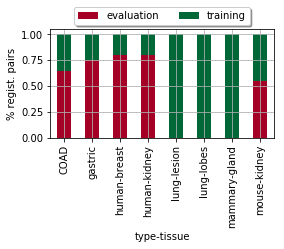

In [11]:
# add stat of train/test for tussie
df_tissue_stat = pd.DataFrame([(cs['name-tissue'], cs[FIELD_TISSUE], cs[FIELD_STATUS])
                               for cs in user_cases[users[0]].values()],
                              columns=['name', FIELD_TISSUE, FIELD_STATUS])
df_tissue_stat.set_index('name', inplace=True)

# compute cumulative stat
dfx = grouping_cumulative(df_tissue_stat, col_index=FIELD_TISSUE, col_column=FIELD_STATUS)
display(dfx.T)

# show results
# ax = dfx.plot(kind='bar', stacked=True, figsize=(len(dfx) / 2, 3), grid=True, cmap='RdYlGn')
# _= plt.ylabel('# regist. pairs')
# ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_tissue-status_abs.pdf'))

# normalize over the sum of all cases
dfx = (dfx.T / dfx.T.sum().astype(float)).T
ax = dfx.plot(kind='bar', stacked=True, figsize=(len(dfx) / 2, 2), grid=True, cmap='RdYlGn')
_= plt.ylabel('% regist. pairs')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True)
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_tissue-status_rltv.pdf'))

## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [12]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE')]:
    # Compute ranking per user in selected metric `field` over all dataset
    user_cases = compute_ranking(user_cases, field)
    for user in users:
        # iterate over Robust or all cases
        for robust in [True, False]:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            s_robust = '-Robust' if robust else ''
            user_aggreg[user]['Average-Rank-' + field_agg + s_robust] = np.mean(vals)
        # iterate over all tissue kinds
        for tissue in tissues:
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if user_cases[user][cs][FIELD_TISSUE] == tissue]
            user_aggreg[user]['Average-Rank-' + field_agg + '_tissue_' + tissue] = np.mean(vals)

Show the raw table with global statiscit (joint training and testing/evalaution).

In [13]:
cols_general = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_'])]
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_general]
display(dfx)

,Average-Average-rTRE,Average-Average-rTRE-Robust,Average-Max-rTRE,Average-Max-rTRE-Robust,Average-Median-rTRE,Average-Median-rTRE-Robust,Average-Norm-Time,Average-Norm-Time-Robust,Average-Rank-Max-rTRE,Average-Rank-Max-rTRE-Robust,Average-Rank-Median-rTRE,Average-Rank-Median-rTRE-Robust,Average-Robustness,Average-used-landmarks,Median-Average-rTRE,Median-Average-rTRE-Robust,Median-Max-rTRE,Median-Max-rTRE-Robust,Median-Median-rTRE,Median-Median-rTRE-Robust,Median-Norm-Time,Median-Norm-Time-Robust
UPENN,0.007928,0.004055,0.028816,0.023239,0.006694,0.002786,1.451193,1.450145,4.234927,4.234927,3.403326,3.403326,0.961813,1.0,0.003044,0.003009,0.018787,0.017621,0.001957,0.001916,1.374846,1.374846
AGH,0.009508,0.005652,0.035654,0.030191,0.007717,0.003809,6.863679,6.843671,6.226611,6.226611,3.567568,3.567568,0.950095,1.0,0.003427,0.003364,0.023538,0.023327,0.001985,0.001951,5.791019,5.767510
MEVIS,0.009043,0.004305,0.031824,0.024638,0.007726,0.002891,0.145392,0.145661,4.825364,4.825364,2.979210,2.979210,0.957428,1.0,0.002974,0.002888,0.018967,0.018641,0.001835,0.001804,0.141754,0.142115
TUB,0.008698,0.003621,0.021063,0.013630,0.008069,0.002956,0.000705,0.000711,2.465696,2.445833,2.844075,2.822917,0.964884,1.0,0.001383,0.001294,0.005417,0.004976,0.001122,0.001054,0.000510,0.000510
CKVST,0.009782,0.005802,0.031627,0.025858,0.008387,0.004363,7.127142,7.181638,5.825364,5.825364,6.280665,6.280665,0.946573,1.0,0.004730,0.004618,0.021181,0.020771,0.003405,0.003310,7.488842,7.535469
TUNI,0.013359,0.006282,0.039503,0.028236,0.011742,0.004723,10.320549,9.143491,6.370062,5.810069,5.993763,5.395881,0.863272,1.0,0.003803,0.003335,0.023673,0.020633,0.002572,0.002220,8.977965,8.761581
RVSS,0.044882,0.012583,0.099775,0.042524,0.042692,0.010759,4.723187,5.086644,8.523909,8.033254,9.640333,9.289786,0.789600,1.0,0.007117,0.005525,0.029633,0.024136,0.005521,0.004161,4.881740,5.185145
UA,0.058755,0.014793,0.121473,0.043618,0.056760,0.013189,1.470925,1.468588,8.912682,8.721133,10.137214,10.002179,0.791234,1.0,0.011282,0.008984,0.036575,0.031934,0.009384,0.007338,1.367489,1.372182
DROP,0.062323,0.032012,0.123775,0.075667,0.061971,0.031154,3.406355,3.467314,7.288981,7.172340,6.869023,6.748936,0.870923,1.0,0.004462,0.003870,0.026948,0.023656,0.002814,0.002544,3.388050,3.415708
Elastix,0.070033,0.043182,0.138686,0.099748,0.068819,0.041281,2.962337,3.255342,8.798337,8.704741,9.831601,9.778017,0.742861,1.0,0.008259,0.005356,0.039672,0.028618,0.005652,0.003924,2.682059,2.943414


In [14]:
col_ranking = 'Average-Rank-Median-rTRE'
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": %s' % (col_ranking, list(users_ranked)))

METHOD_COLORS = plt.get_cmap('nipy_spectral', len(dfx))
# define cyclic buffer of markers for methods
# https://matplotlib.org/3.1.1/api/markers_api.html
METHOD_MARKERS = list('.*^v<>pPhHXdD')

Odered methods by "Average-Rank-Median-rTRE": ['TUB', 'MEVIS', 'UPENN', 'AGH', 'TUNI', 'CKVST', 'DROP', 'ANTs', 'RVSS', 'bUnwarpJ', 'Elastix', 'UA', 'NiftyReg']


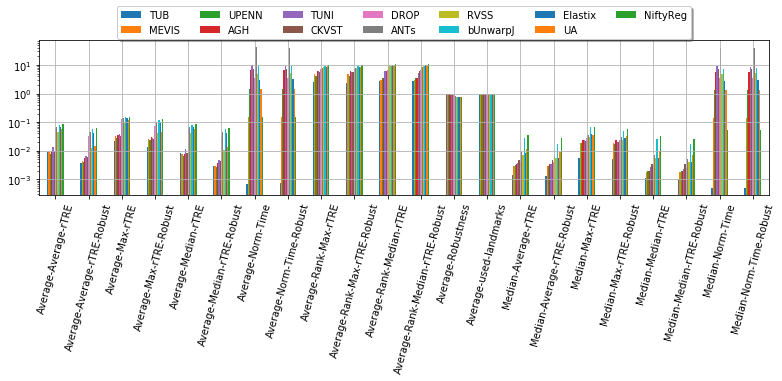

In [15]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_general]
ax = dfx.T.plot.bar(figsize=(len(cols_general) / 2., 6), grid=True, logy=True, rot=75)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_teams-scores.pdf'))
# plt.savefig(os.path.join(PATH_TEMP, 'fig_teams-scores.pdf'), constrained_layout=True)

## Compare statistic "train" vs "test"

Compute sts. on training and testing case also foor newly add rank measures.

In [16]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Median_rank', 'Rank-Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE'),
                         ('rTRE-Max_rank', 'Rank-Max-rTRE'),
                         ('Norm-Time_minutes', 'Norm-Time')]:
    for user in users:
        for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user]['Average-' + field_agg + '_' + state] = np.nanmean(vals)

With given methods order them by particular criterion... Test ARMrTRE

In [17]:
col_ranking = 'Average-Rank-Median-rTRE_' + VAL_STATUS_TEST
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": %s' % (col_ranking, list(users_ranked)))

Odered methods by "Average-Rank-Median-rTRE_evaluation": ['MEVIS', 'AGH', 'UPENN', 'CKVST', 'TUB', 'TUNI', 'DROP', 'ANTs', 'RVSS', 'bUnwarpJ', 'Elastix', 'UA', 'NiftyReg']


In [18]:
# Exporting results to CSV
dfx = pd.DataFrame(user_aggreg).T
cols_train_test = [col for col in dfx.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
dfx.sort_values('Average-Median-rTRE')[cols_train_test].to_csv(
    os.path.join(PATH_TEMP, 'stat-results_train-test.csv'))

Show separatly raw table with statistic for train and test cases separatly.

In [19]:
from IPython.display import display

df_train_eval = pd.DataFrame()

for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    cols = [col for col in cols_train_test if state in col]
    df = pd.DataFrame(user_aggreg).T[cols]
    df.columns = [c.replace('_' + state, '') for c in df.columns]
    df['state'] = state
    df_train_eval = pd.concat([df_train_eval, df])

# df = pd.DataFrame(user_aggreg).T[cols]
# cols = [c for c in df_all_train_eval.columns if 'state' not in c and c in df.columns]
# df = df[cols]
# df['state'] = 'all'
# df_all_train_eval = pd.concat([df_all_train_eval, df])

df_train_eval['method'] = df_train_eval.index
df_train_eval = df_train_eval.set_index(['method', 'state']).sort_index()
df_train_eval.to_csv(os.path.join(PATH_TEMP, 'results-methods_tran-test.csv'))
display(df_train_eval)

Average-Average-rTRE  Average-Max-rTRE  Average-Median-rTRE  Average-Norm-Time  Average-Rank-Max-rTRE  Average-Rank-Median-rTRE  Average-Robustness  Median-Average-rTRE  Median-Max-rTRE  Median-Median-rTRE  Median-Robustness
method   state                                                                                                                                                                                                                                       
AGH      evaluation              0.006080          0.028339             0.003587           6.548090               6.000000                  3.422311            0.974170             0.003220         0.023037            0.001913           1.000000
         training                0.013250          0.031823             0.004042           7.208083               6.473913                  3.726087            0.923822             0.003823         0.024291            0.002175           1.000000
ANTs     evaluation              0.099126          0.186060             0.099164          48.241899               7.788845                  9.231076            0.788870             0.007222         0.035078            0.005799           0.971429
         training                0.037758          0.077806             0.035289          37.472631               7.895652                  8.826087            0.816045             0.011185         0.038665            0.008707           0.969669
CKVST    evaluation              0.005099          0.023934             0.002693           7.795553               5.274900                  4.406375            0.980415             0.003256         0.018919            0.002267           1.000000
         training                0.014893          0.028522             0.006701           6.397704               6.426087                  8.326087            0.909641             0.006199         0.023126            0.005139           1.000000
DROP     evaluation              0.086123          0.164415             0.086654           3.993030               7.430279                  7.055777            0.882477             0.004216         0.027342            0.002780           0.989247
         training                0.036349          0.077716             0.033706           2.766114               7.134783                  6.665217            0.858313             0.004717         0.026451            0.002904           0.990654
Elastix  evaluation              0.097475          0.185674             0.095648           3.496669               8.876494                 10.043825            0.801832             0.007977         0.037874            0.005974           0.971223
         training                0.040086          0.083994             0.038734           2.379218               8.713043                  9.600000            0.678507             0.008457         0.041956            0.005506           0.959184
MEVIS    evaluation              0.005161          0.025107             0.002870           0.166606               5.035857                  2.840637            0.980057             0.002740         0.019184            0.001790           1.000000
         training                0.013278          0.027120             0.004924           0.122241               4.595652                  3.130435            0.932733             0.003095         0.018965            0.001901           1.000000
NiftyReg evaluation              0.111982          0.201039             0.113601           0.136389              10.083665                 11.075697            0.742689             0.037248         0.071369            0.035508           0.851852
         training                0.051206          0.097324             0.049148           0.167288              10.152174                 10.430435            0.725708             0.033683         0.067267            0.031444           0.830952
RVSS     evaluation              0.047214          0.104800             0.044767     

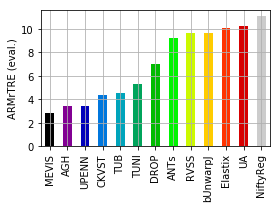

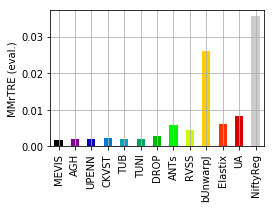

In [20]:
for col, name in [('Average-Rank-Median-rTRE_evaluation', 'ARMrTRE (eval.)'),
                  ('Median-Median-rTRE_evaluation', 'MMrTRE (eval.)')]:
    plt.figure(figsize=(4, 3))
    ax = pd.DataFrame(user_aggreg)[users_ranked].T[col].plot.bar(
        grid=True, rot=90, color=[METHOD_COLORS(i) for i, _ in enumerate(users_ranked)])
    # ax = pd.DataFrame(user_aggreg).T.sort_values(col)[col].plot.bar(grid=True, rot=90, color='blue')
    _= plt.ylabel(name)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bar_teams-scores_%s.pdf' % col))

Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [21]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['method'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try:
        df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception:
        print (col)
# df_cases.head()

Status
name-reference
name-source
name-tissue
type-tissue
method


### Showing several violine plots

In [22]:
def _format_ax(ax, name, log, vmax):
    plt.xticks(rotation=60)
    if log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.get_figure().tight_layout()

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


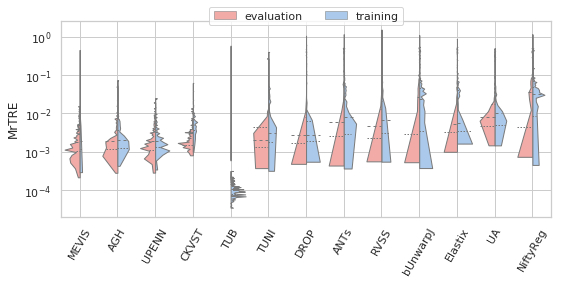

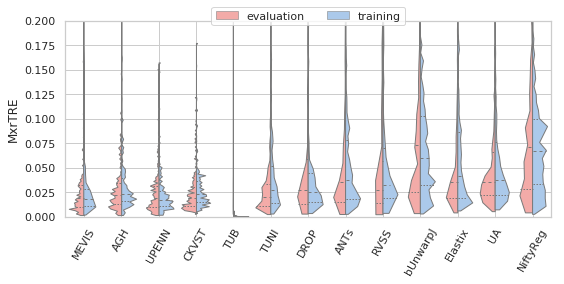

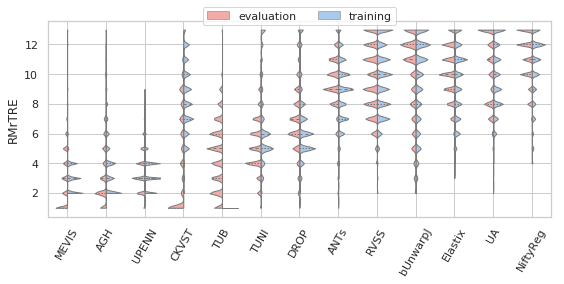

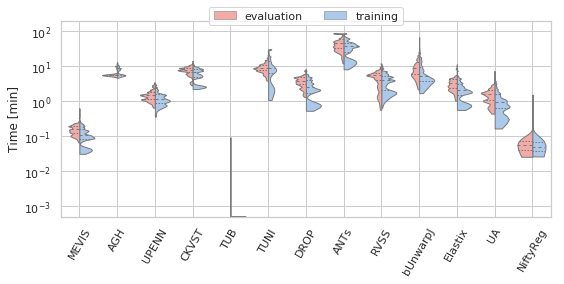

In [23]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   # ('rTRE-Median', '', False, 0.1, 0.01),
                                   ('rTRE-Max', 'MxrTRE', False, 0.2, 0.02),
                                   ('rTRE-Median_rank', 'RMrTRE', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 200, 0.1)]:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(ax=ax, data=df_cases, hue='Status', y=field, x='method', order=users_ranked,
                   cut=0, split=True, bw=bw, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1.)
    _format_ax(ax, name, log, vmax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, shadow=False)
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'hist_teams-scores_%s.pdf' % field))

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


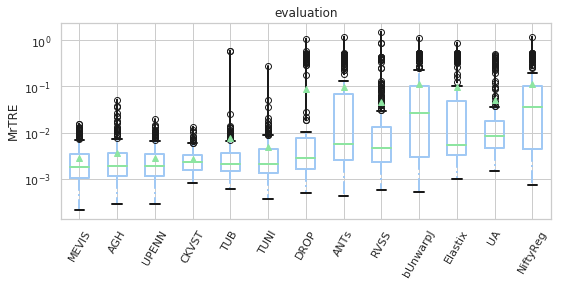

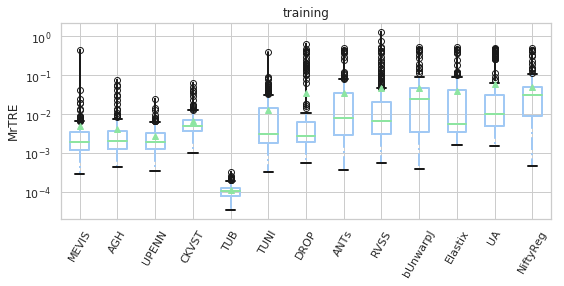

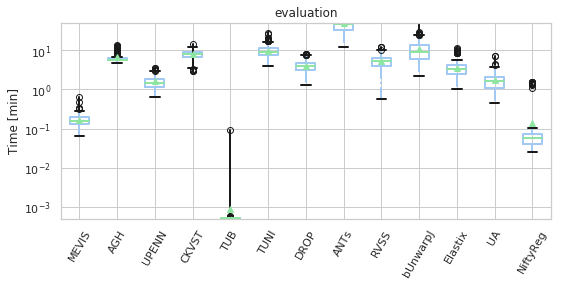

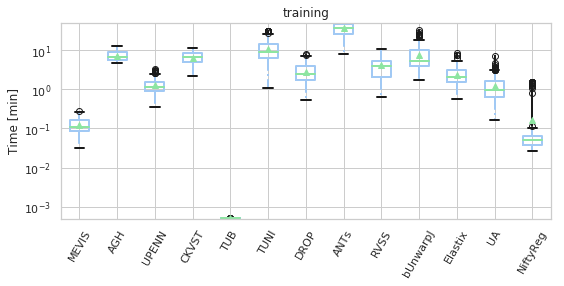

In [24]:
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   # ('rTRE-Median_rank', 'RMrTRE', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 50, 0.1)]:
    for st, dfg in df_cases.groupby('Status'):
        # methods_ = list(dfg['method'].unique())
        vals_ = [dfg[dfg['method'] == m][field].values for m in users_ranked]
        dfg_ = pd.DataFrame(np.array(vals_).T, columns=users_ranked)
        fig, ax = plt.subplots(figsize=(8, 4))
        bp = dfg_.plot.box(ax=ax, showfliers=True, showmeans=True, 
                           color=dict(boxes='b', whiskers='b', medians='g', caps='k'),
                           boxprops=dict(linestyle='-', linewidth=2),
                           flierprops=dict(linestyle='-', linewidth=2),
                           medianprops=dict(linestyle='-', linewidth=2),
                           whiskerprops=dict(linestyle='-.', linewidth=2),
                           capprops=dict(linestyle='-', linewidth=2),
                           return_type='dict')
        _format_ax(ax, name, log, vmax)
        ax.set_title(st)
        ax.get_figure().savefig(os.path.join(PATH_TEMP, 'boxbar_teams-scores_%s_%s.pdf' % (field, st)))

## Visualise global results

/home/jb/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


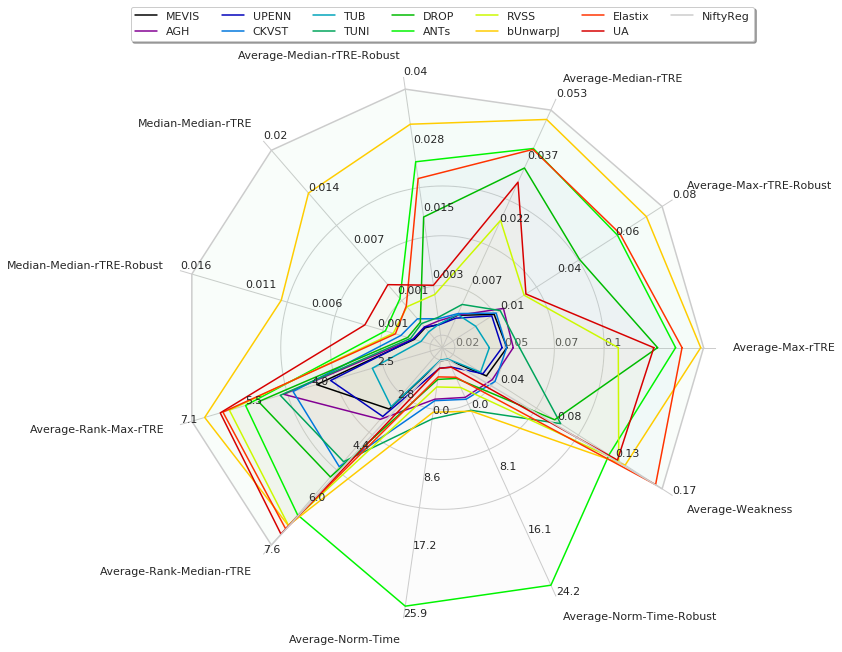

In [25]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg)[users_ranked].T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(9, 8)))
radar.ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
                ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
radar.fig.tight_layout()
radar.fig.savefig(os.path.join(PATH_TEMP, 'radar_teams-scores.pdf'))

## Visualise partial rankings

With given metrics compute ranking among all participants, so each user has a unique colour and then the users are sorted in ascending order...

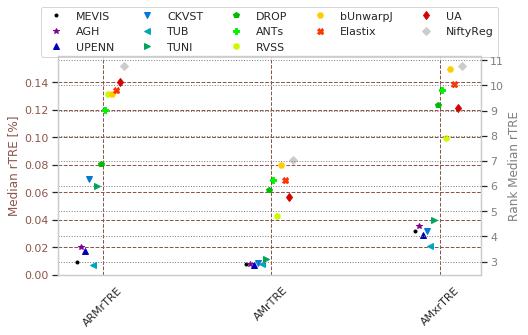

In [26]:
# cols = [c for c in cols_general if not any([n in c for n in ('Robust', 'Time', 'landmarks')])]
cols = ['Average-Rank-Median-rTRE', 'Average-Median-rTRE', 'Average-Max-rTRE']
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols]

cols_rank = [c for c in cols if 'Rank-' in c]
# https://matplotlib.org/3.1.1/api/markers_api.html
fig, (ax, _) = draw_scatter_double_scale(
    dfx, cmap=METHOD_COLORS, ax_decs={'Median rTRE [%]': None, 'Rank Median rTRE': cols_rank},
    idx_markers=METHOD_MARKERS, xlabel='Methods', figsize=(1 + len(dfx) * 0.5, 5),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2, 4), grid=True)
# _= plt.xlim([-0.5, len(cols) - 0.5])
# _= plt.yscale('log'), plt.ylabel('Median-rTRE [%]')

# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
# _= plt.xticks(range(len(cols)), [col_metric_rename(c) for c in cols], rotation=90)
ax.set_xlabel('')
ax.set_xticks(range(len(cols)))
ax.set_xticklabels([col_metric_rename(c) for c in cols], rotation=45, ha="center")
# ax.legend(, fancybox=True, shadow=True)
fig.tight_layout()
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores.pdf'))

/home/jb/Dropbox/Workspace/BIRL/birl/utilities/evaluate.py:223: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ranking = np.zeros(df_stat.as_matrix().shape)
/home/jb/Dropbox/Workspace/BIRL/birl/utilities/drawing.py:467: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  fig, _ = plt.subplots(figsize=np.array(df_stat.as_matrix().shape[::-1]) * 0.35)


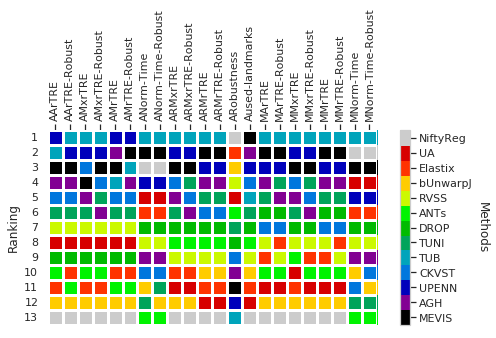

In [27]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_general]
dfx.columns = [col_metric_rename(c) for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_all.pdf'))

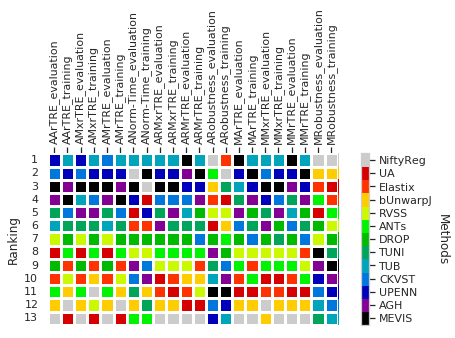

In [28]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_train_test]
dfx.columns = [col_metric_rename(c) for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_train-test.pdf'))

## Visual statistic over tissue types

Present some statistis depending on the tissue types...

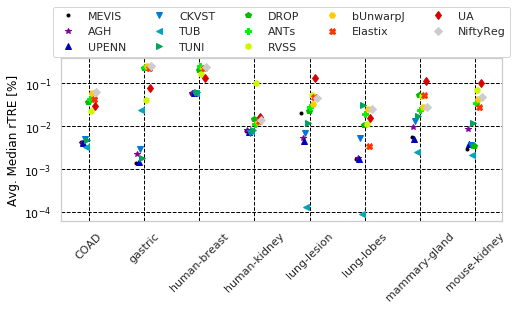

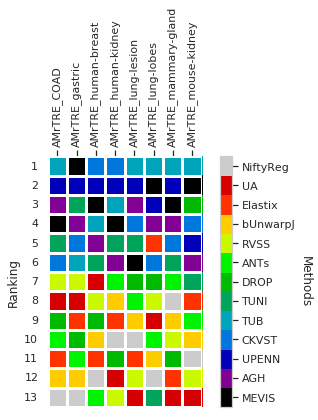

In [29]:
col_avg_med_tissue = sorted([c for c in pd.DataFrame(user_aggreg).T.columns
                             if 'Median-rTRE_tissue' in c and not 'Rank' in c and 'Median-Median-' not in c])

dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col_avg_med_tissue]
# colors = plt.get_cmap('nipy_spectral', len(dfx))
fig, (ax, _) = draw_scatter_double_scale(
    dfx, cmap=METHOD_COLORS, ax_decs={'Avg. Median rTRE [%]': None},
    idx_markers=METHOD_MARKERS, xlabel='Methods', figsize=(1 + len(dfx) * 0.5, 5),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2 + 1, 5), grid=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
ax.set_xticks(range(len(col_avg_med_tissue)))
ax.set_xticklabels([col_metric_rename(c).replace('AMrTRE_tissue_', '') for c in col_avg_med_tissue],
                   rotation=45, ha="center")

# _= plt.xlim([-0.5, len(col_avg_med_tissue) - 0.5])
ax.set_xlabel('')
ax.set_yscale('log')
# _= plt.ylabel('Avg / Median - Median-rTRE')
fig.tight_layout()
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-avg.pdf'))

dfx.columns = [col_metric_rename(c).replace('_tissue', '').replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx, fig=plt.figure(figsize=(6, 6)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-avg.pdf'))

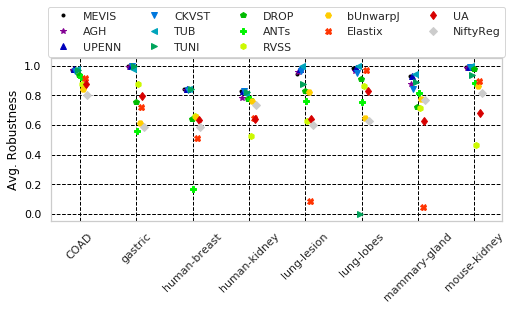

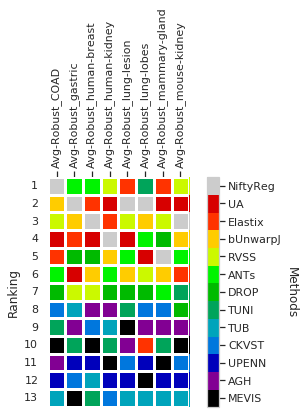

In [30]:
col_robust_tissue = sorted([c for c in pd.DataFrame(user_aggreg).T.columns
                            if 'Average-Robustness_tissue' in c and not 'Rank' in c])
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col_robust_tissue]
fig, (ax, _) = draw_scatter_double_scale(
    dfx, cmap=METHOD_COLORS, ax_decs={'Avg. Robustness': None},
    idx_markers=METHOD_MARKERS, xlabel='Methods', figsize=(1 + len(dfx) * 0.5, 5),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2, 5), grid=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
ax.set_xlabel('')
ax.set_xticks(range(len(col_robust_tissue)))
ax.set_xticklabels([col_tissue_remane(c).replace('Average-Robustness_tissue_', '') for c in col_robust_tissue],
                   rotation=45, ha="center")

# _= plt.xlim([-0.5, len(col_robust_tissue) - 0.5])
fig.tight_layout()
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-robust.pdf'))

dfx.columns = [col_tissue_remane(c).replace('Average-Robustness_tissue', 'Avg-Robust') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx, fig=plt.figure(figsize=(6, 6)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-robust.pdf'))

## Calculating pairwise significance

In [31]:
cases=[k for k in submissions[users[0]]['cases'].keys() if submissions[users[0]]['cases'][k][FIELD_STATUS] == 'evaluation' ]
print ('# cases: ', len(cases))

# cases:  251


Difference is not significant between ANTs and AGH for p=0.013812
Difference is not significant between CKVST and ANTs for p=0.080876
Difference is not significant between DROP and AGH for p=0.346996
Difference is not significant between DROP and ANTs for p=0.584593
Difference is not significant between DROP and CKVST for p=0.555604
Difference is not significant between TUB and RVSS for p=0.674422
Difference is not significant between UA and RVSS for p=0.078941
Difference is not significant between UA and TUNI for p=1.000000
Difference is not significant between UPENN and RVSS for p=0.422872
Difference is not significant between UPENN and TUNI for p=0.999947
Difference is not significant between UPENN and UA for p=0.569634


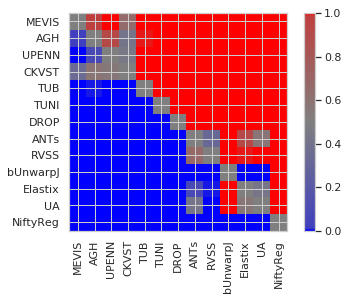

In [32]:
import matplotlib.colors
from scipy.stats import wilcoxon

r = {m: list(map(lambda c: submissions[m]['cases'][c]['rTRE-Median'], cases)) for m in users}
x = r[users[0]]
y = r[users[1]]

ps = np.zeros((len(users), len(users)))
for i, j in ((i, j) for i in range(len(users)) for j in range(len(users))):
    ps[i, j] = 0.5
    if i != j:
        s, p = wilcoxon(r[users_ranked[i]], r[users_ranked[j]], alternative='greater')
        if i > j and p > 0.01:
            print('Difference is not significant between %s and %s for p=%f' % (users[i], users[j], p))
        ps[i, j] = p

cvals = [0., 0.01, 0.5, 0.99, 1.0]
colors = [[0, 0, 1], [0.25, 0.25, 0.75], [0.5, 0.5, 0.5], [0.75, 0.25, 0.25], [1., 0, 0]]
cvals_norm = plt.Normalize(min(cvals), max(cvals))
cvals_color = list(zip(map(cvals_norm, cvals), colors))   
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cvals_color)        
plt.imshow(ps, interpolation='nearest', cmap=cmap, norm=cvals_norm)
plt.colorbar()
_= plt.xticks(range(len(users)), users_ranked, rotation=90)
_= plt.yticks(range(len(users)), users_ranked)
plt.gca().get_figure().savefig(os.path.join(PATH_TEMP, 'wilcoxon_teams_rTRE.pdf'), bbox_inches='tight')